# MSNM-S experimental results 
See the pre-print work at (arxiv link)


In [49]:
import json
import numpy as np
import pandas as pd
import scipy.io as sio
from datetime import date,timedelta,datetime
from dateutil import parser
from pprint import pprint
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
pd.set_option('display.max_rows',15) # this limit maximum numbers of rows

In [50]:
# Extra configuration paremeters for the graphics to be displayed

# fondict for axis labels
font_labels = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 22}
# fondict for title labels
font_title = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 22}
# fontsize for tickso
ticks_fontsize=16

In [51]:
# Folders to be configured

#base path
base_path='../data/metis_batch_60obs/'
#data path
data_path= base_path + '20170920_182121/'
#data_path= base_path + '20171004_172852/'
#ouput dir
outputs=base_path + 'outputs/'
#fig dir
figs=outputs + 'figs/'

In [52]:
def get_monitoring(monFilesPath):
    
    """
    Gets all the monitoring information (Q,D) from *.dat monitoring files
    """
            
    # Get the name of the files ordered
    filesOrdered = np.sort(os.listdir(monFilesPath))
            
    print("Total files to process: " + str(len(filesOrdered)))
    
    # Contains the ts of each file encountered in the file system
    d_range = []
    
    # Data matrix from all monitoring files and statistics values involved
    mon_data = np.empty((len(filesOrdered),4))
    
    # Finding missing files
    file_counter = 0
    for i in filesOrdered:
        ts_file = i[7:][0:-4]
        d_range.append(ts_file)
        
        # Getting values
        with open(monFilesPath + filesOrdered[file_counter]) as f:
            control_limits = f.readline()
            q_d_values = f.readline()
            
        # Getting control limits values
        control_limits = control_limits[1:]# Removing '#' character
        UCLq = control_limits.split(',')[0].split(':')[1]
        UCLd = control_limits.split(',')[1].split(':')[1]
        UCLd = UCLd.replace('\n','')
       
        # Getting Q and D values
        Qst = q_d_values.split(',')[0]
        Dst = q_d_values.split(',')[1]
        Dst = Dst.replace('\n','')
        
        # All together
        mon_data[file_counter,:] = np.array([Qst,Dst,UCLq,UCLd])
        
        file_counter = file_counter + 1
        
    # Dataframe data
    data = {'ts':d_range,'files':filesOrdered}
    
    # Create dataframe
    df = pd.DataFrame(data)
    
    # Dataframe containing the 
    df_statistics = pd.DataFrame(mon_data,columns=['Qst','Dst','UCLq','UCLd'])
    
    # Concat both of them
    df_complete = pd.concat([df,df_statistics],axis=1)

    return df_complete, mon_data

In [53]:
def get_obs(obsFilesPath):
        
    """
    Gets all the obsertavions from *.dat files
    """
            
    # Get the name of the files ordered
    filesOrdered = np.sort(os.listdir(obsFilesPath))
            
    print("Total files to process: " + str(len(filesOrdered)))
    
    # Contains the ts of each file encountered in the file system
    d_range = []
    
    # Finding missing files
    for i in filesOrdered:
        ts_file = i[4:][0:-4]
        d_range.append(ts_file)
        
    # Dataframe data
    data = {'ts':d_range,'files':filesOrdered}
    
    # Create dataframe
    df = pd.DataFrame(data)
    
    # Getting variables names
    with open(obsFilesPath + filesOrdered[0]) as f:
        variables = f.readline()
    
    # removing '#' header char
    variables = variables[1:]
    var_parsed = []
    for item in variables.split(','):
        item = item.replace('[','').replace(']','').replace('\n','').replace(' ','').replace("'","")        
        var_parsed.append(item)
    
    # Data matrix from all obs files
    obs_data = np.empty((len(filesOrdered),len(var_parsed)))
    print(obs_data.shape)
    
    # Dataframe data from files
    obs = 0
    for obs_file in filesOrdered:        
        obs_data_file = np.loadtxt(obsFilesPath + obs_file, comments="#", delimiter=",", skiprows=1)
        obs_data[obs,:] = obs_data_file
        obs = obs + 1
    df_files = pd.DataFrame(obs_data,columns=var_parsed)
    
    # Concat both dataframes
    df_complete = pd.concat([df,df_files],axis=1)
    
    return df_complete, obs_data

In [54]:
def draw_mon_graph(device_name, obs_interval,fig=None,ax=None, save=True, st=['Qst','Dst'],cl=['UCLd','UCLq']):
    """
    Draw and save monitoring graphics
    
    Observation intervals in monitoring graphs.
    They can be: 
    - 'all': df_mon (all the data)
    - 'anomaly': df_mon[df_mon.ts >= pd.to_datetime(anomaly_init.values[0])] (anomaly interval: 
    from the begining of anomaly interval to the end)
    - 'test': df_mon[df_mon.ts >= pd.to_datetime(test_init.values[0])] (test interval: 
    from the begining of test interval to the end)
    
    NOTE: df_mon, test_init and anomaly_init should be definied outside.
    
    """
    
    # Graph title
    title=device_name
    
    go = True

    if obs_interval == 'all':
        df_mon_filtered = df_mon
        resample = '30T'
    elif obs_interval == 'anomaly':
        df_mon_filtered = df_mon[df_mon.ts >= pd.to_datetime(anomaly_init.values[0])]
        resample = '5T'
        title=title + ' (attacks)'
    elif obs_interval == 'test':
        df_mon_filtered = df_mon[df_mon.ts >= pd.to_datetime(test_init.values[0])]
        resample = '5T'
        title=title + ' (attacks)'
    else:
        print('Please select a valid observation interval')
        go = False

    if go:
                    
        ax.set_yscale('log')

        df_all=df_mon_filtered.set_index(df_mon_filtered.ts)
        df_qd=df_all[st]
        df_cl=df_all[cl]
        
        legend=[]
        
        if 'Qst' in st: 
            plt.plot(df_qd['Qst'], 'v:')
            legend.append('Qst')
        if 'Dst' in st: 
            plt.plot(df_qd['Dst'], 'o-.')
            legend.append('Dst')
        if 'UCLq' in cl: 
            plt.plot(df_cl['UCLq'],'--')
            legend.append('UClq')
        if 'UCLd' in cl: 
            plt.plot(df_cl['UCLd'],'-')
            legend.append('UCLd')
            
        plt.legend(legend, fontsize=ticks_fontsize, loc='upper left')

        #fig.autofmt_xdate()
        ax.set_xticks(df_qd.resample(resample).sum().index)
        ax.set_xticklabels(df_qd.resample(resample).sum().index)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        #ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))

        plt.xticks(rotation=65)

        ax.set_xlabel('Observation time', fontdict=font_labels)
        ax.set_ylabel('Value (log)',fontdict=font_labels)

        plt.grid()
        plt.tick_params(axis='both', labelsize=ticks_fontsize)
        plt.title(title,fontdict=font_title)
                    
        if save:
            fig.tight_layout()    
            plt.savefig(figs + device_name + '_' + obs_interval + '_q_d.pdf')           
        
        return fig, ax
        


## Border Router
Border Router (BR) monitoring analysis

In [55]:
device_name = "borderRouter"

# observations path
obs_path = data_path + device_name + '/data/monitoring/observation/'

# Get test data
df,obs_data = get_obs(obs_path)

# Some conversions
df['ts'] = pd.to_datetime(df['ts'],format='%Y%m%d%H%M')

# Last observation
last_obs = df.iloc[-1:]['ts']

# Initial ts of the anomaly data set
anomaly_init = last_obs - timedelta(minutes=90)

# Initial ts of the test data set
test_init = anomaly_init - timedelta(minutes=90)



Total files to process: 1481
(1481, 150)


### Border Router Monitoring statistics evolution
$Q$ and $D$ monitoring statistics analysis and evolution. Detected anomalies are those observations exceeding the 
control limits.

Since the BR aggregates all the monitoring statistics from sensors in lower levels of the hierarchy, it is able to detect all the generated attacks.

In [56]:
# monitoring path
mon_path = data_path + device_name + '/data/monitoring/output/'

# Get all monitoring values from each observation
df_mon, mon_data = get_monitoring(mon_path)

# Some conversions
df_mon['ts'] = pd.to_datetime(df_mon['ts'],format='%Y%m%d%H%M')

Total files to process: 1481


In [57]:
# All data gathered from the experiment ('all')
fig, ax = plt.subplots(figsize=(15,10))
draw_mon_graph(device_name=device_name,obs_interval='all',fig=fig, ax=ax, save=True, st=['Qst','Dst'], cl=['UCLq','UCLd'])
# The data considering the anomaly time interval ('anomaly') where the attacks took place.
fig, ax = plt.subplots(figsize=(15,10))
draw_mon_graph(device_name=device_name,obs_interval='anomaly',fig=fig, ax=ax, save=True, st=['Qst','Dst'], cl=['UCLq','UCLd'])


(<matplotlib.figure.Figure at 0x7f6d57e58080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6d57da6978>)

## Router 1
Router 1 (R1) monitoring analysis

In [58]:
device_name = "routerR1"

# observations path
obs_path = data_path + device_name + '/data/monitoring/observation/'

# Get test data
df,obs_data = get_obs(obs_path)

# Some conversions
df['ts'] = pd.to_datetime(df['ts'],format='%Y%m%d%H%M')

# Last observation
last_obs = df.iloc[-1:]['ts']
# Initial ts of the anomaly data set
anomaly_init = last_obs - timedelta(minutes=90)
# Initial ts of the test data set
test_init = anomaly_init - timedelta(minutes=90)


Total files to process: 1502
(1502, 144)


### Router R1 monitoring statistics evolution
$Q$ and $D$ monitoring statistics analysis and evolution. Detected anomalies are those observations exceeding the control limits.

Since *port scanning* attack is originated at the R1 subnetwork, the sensor deployed at R1 is able to detect this attack.

In [59]:
# monitoring path
mon_path = data_path + device_name + '/data/monitoring/output/'

# Get all monitoring values from each observation
df_mon, mon_data = get_monitoring(mon_path)

# Some conversions
df_mon['ts'] = pd.to_datetime(df_mon['ts'],format='%Y%m%d%H%M')

Total files to process: 1502


(<matplotlib.figure.Figure at 0x7f6d57b10518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6d57e41cc0>)

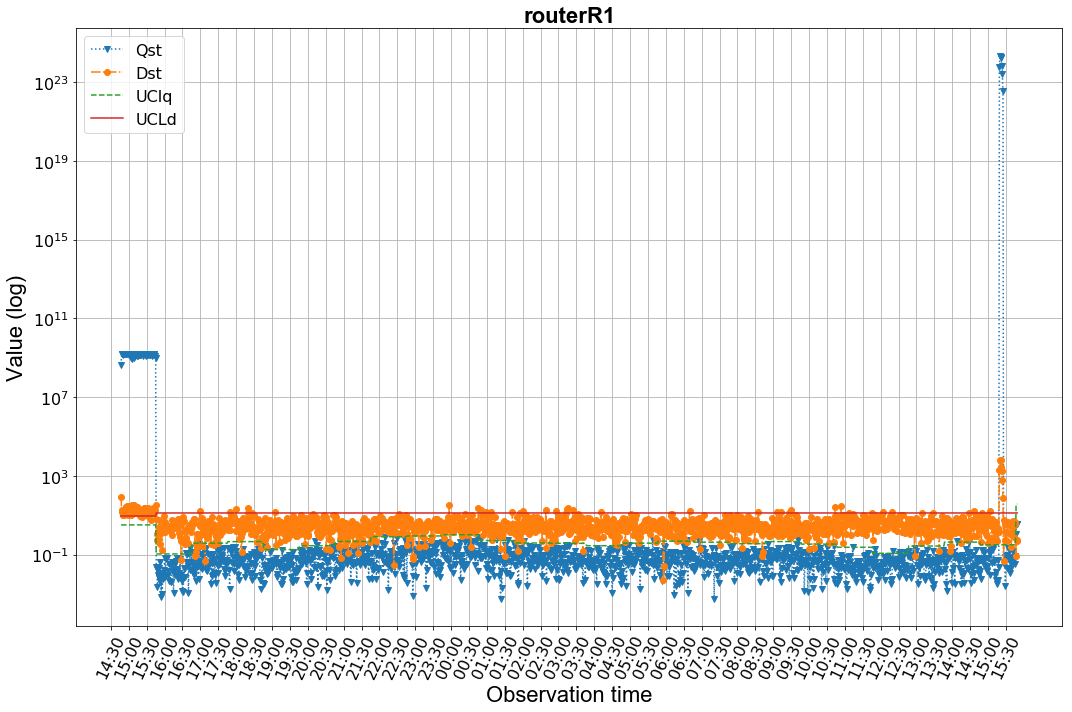

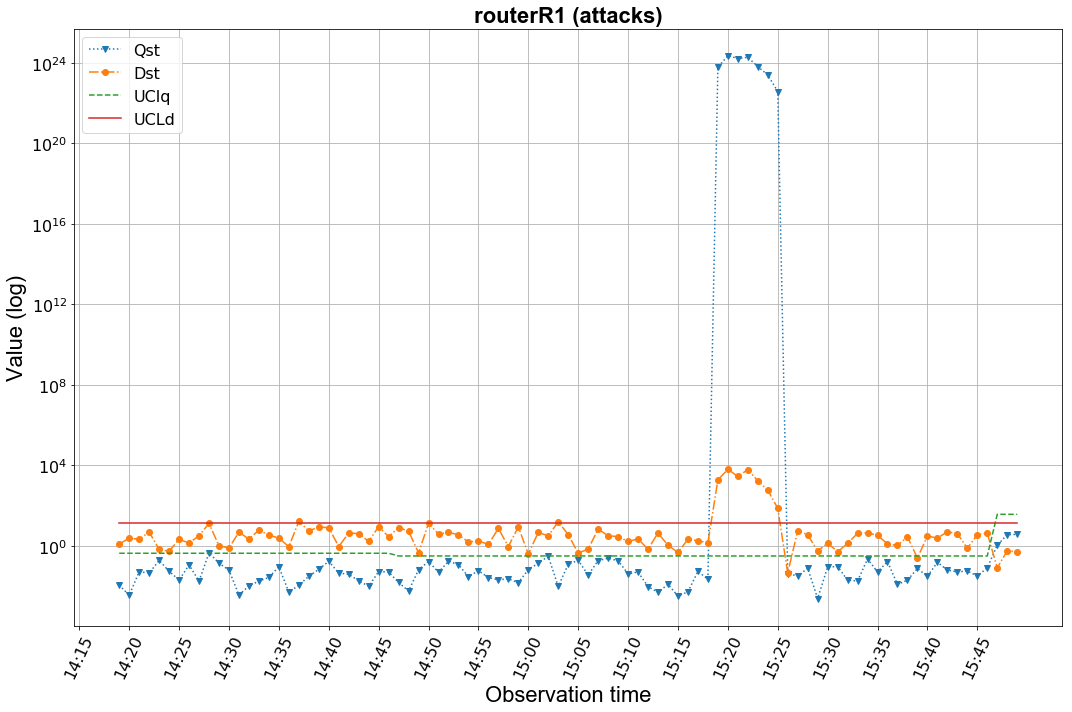

In [60]:
# All data gathered from the experiment ('all')
fig, ax = plt.subplots(figsize=(15,10))
draw_mon_graph(device_name=device_name,obs_interval='all',fig=fig, ax=ax, save=True, st=['Qst','Dst'], cl=['UCLq','UCLd'])
# The data considering the anomaly time interval ('anomaly') where the attacks took place.
fig, ax = plt.subplots(figsize=(15,10))
draw_mon_graph(device_name=device_name,obs_interval='anomaly',fig=fig, ax=ax, save=True, st=['Qst','Dst'], cl=['UCLq','UCLd'])

## Router 2
Router 2 (R2) monitoring analysis

In [61]:
device_name = "routerR2"

# observations path
obs_path = data_path + device_name + '/data/monitoring/observation/'

# Get test data
df,obs_data = get_obs(obs_path)

# Some conversions
df['ts'] = pd.to_datetime(df['ts'],format='%Y%m%d%H%M')

# Last observation
last_obs = df.iloc[-1:]['ts']
# Initial ts of the anomaly data set
anomaly_init = last_obs - timedelta(minutes=90)
# Initial ts of the test data set
test_init = anomaly_init - timedelta(minutes=90)



Total files to process: 1477
(1477, 144)


### Router R2 monitoring statistics evolution
$Q$ and $D$ monitoring statistics analysis and evolution. Detected anomalies are those observations exceeding the control limits.

Since *data exfiltration* attack is originated at the R2 subnetwork, the sensor deployed at R2 is able to detect this attack.

In [62]:
# monitoring path
mon_path = data_path + device_name + '/data/monitoring/output/'

# Get all monitoring values from each observation
df_mon, mon_data = get_monitoring(mon_path)

# Some conversions
df_mon['ts'] = pd.to_datetime(df_mon['ts'],format='%Y%m%d%H%M')

Total files to process: 1477


(<matplotlib.figure.Figure at 0x7f6d5d415ac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6d57dca6d8>)

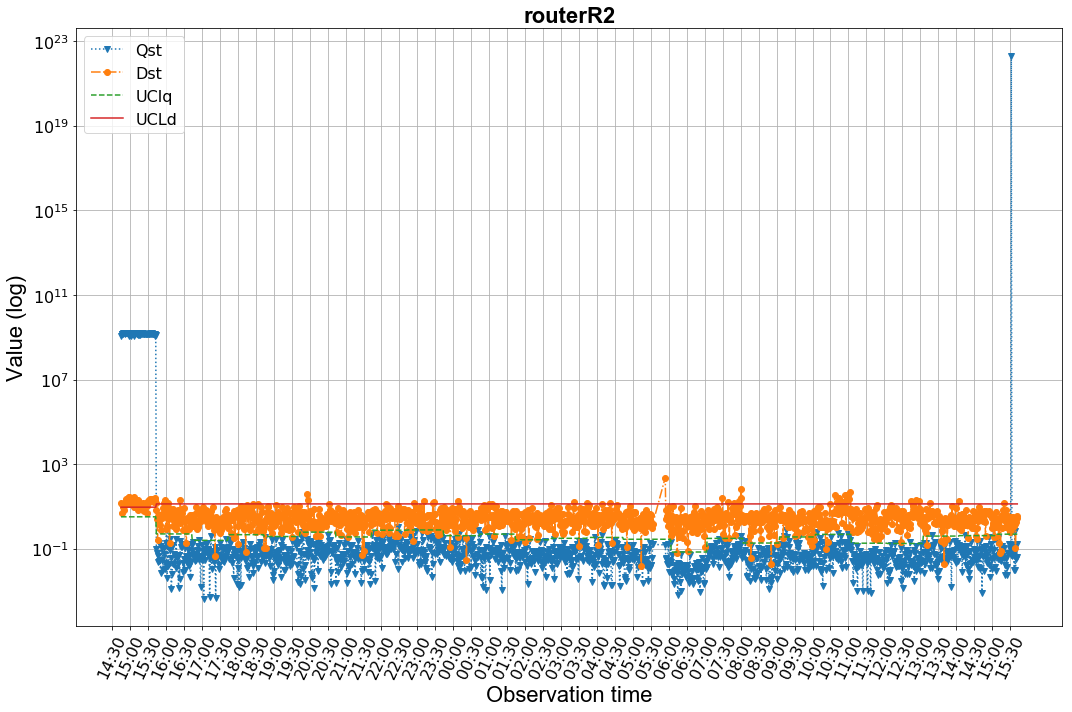

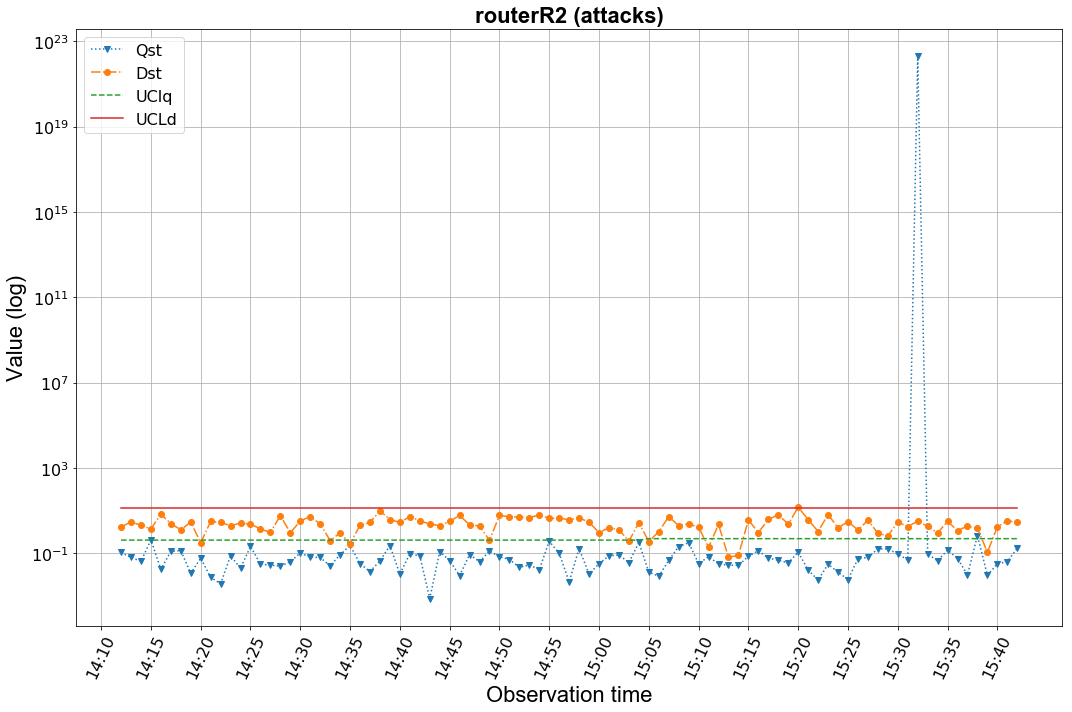

In [63]:
# All data gathered from the experiment ('all')
fig, ax = plt.subplots(figsize=(15,10))
draw_mon_graph(device_name=device_name,obs_interval='all',fig=fig, ax=ax, save=True, st=['Qst','Dst'], cl=['UCLq','UCLd'])
# The data considering the anomaly time interval ('anomaly') where the attacks took place.
fig, ax = plt.subplots(figsize=(15,10))
draw_mon_graph(device_name=device_name,obs_interval='anomaly',fig=fig, ax=ax, save=True, st=['Qst','Dst'], cl=['UCLq','UCLd'])


## Router 3
Router 3 (R3) monitoring analysis

In [64]:
device_name = "routerR3"

# observations path
obs_path = data_path + device_name + '/data/monitoring/observation/'

# Get test data
df,obs_data = get_obs(obs_path)

# Some conversions
df['ts'] = pd.to_datetime(df['ts'],format='%Y%m%d%H%M')

# Last observation
last_obs = df.iloc[-1:]['ts']
# Initial ts of the anomaly data set
anomaly_init = last_obs - timedelta(minutes=90)
# Initial ts of the test data set
test_init = anomaly_init - timedelta(minutes=90)



Total files to process: 1478
(1478, 144)


### Router R3 monitoring statistics evolution
$Q$ and $D$ monitoring statistics analysis and evolution. Detected anomalies are those observations exceeding the control limits.

Since *DoS* attack is originated at the R3 subnetwork, the sensor deployed at R3 is able to detect this attack.

In [65]:
# monitoring path
mon_path = data_path + device_name + '/data/monitoring/output/'

# Get all monitoring values from each observation
df_mon, mon_data = get_monitoring(mon_path)

# Some conversions
df_mon['ts'] = pd.to_datetime(df_mon['ts'],format='%Y%m%d%H%M')

Total files to process: 1478


(<matplotlib.figure.Figure at 0x7f6d57e582e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6d57aabeb8>)

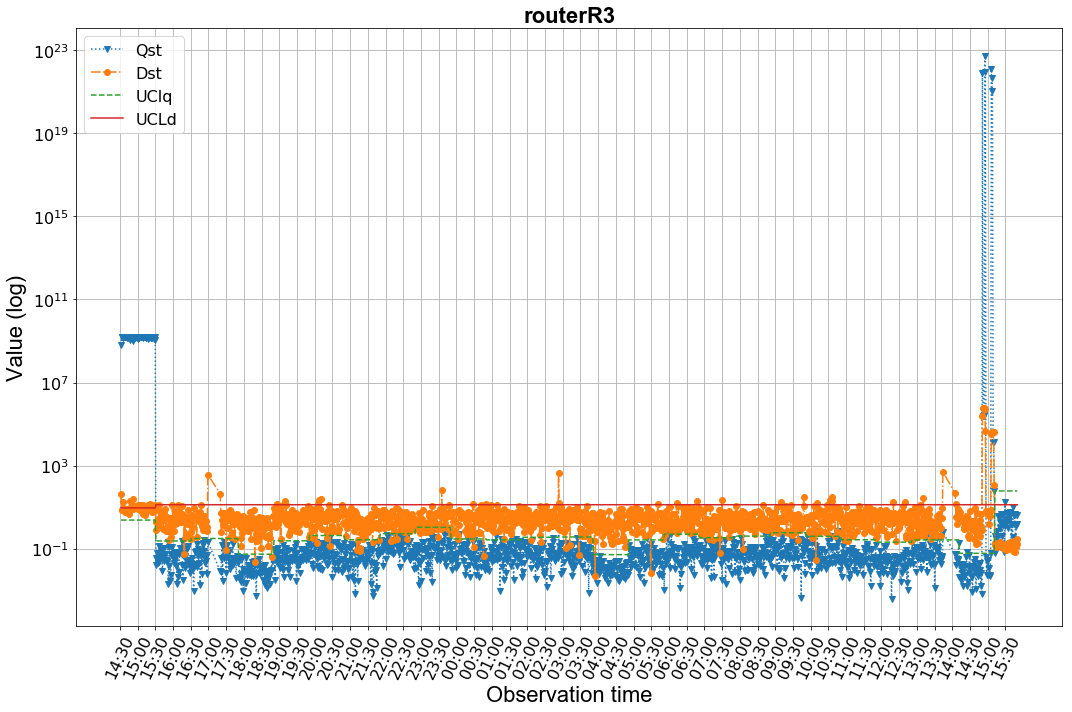

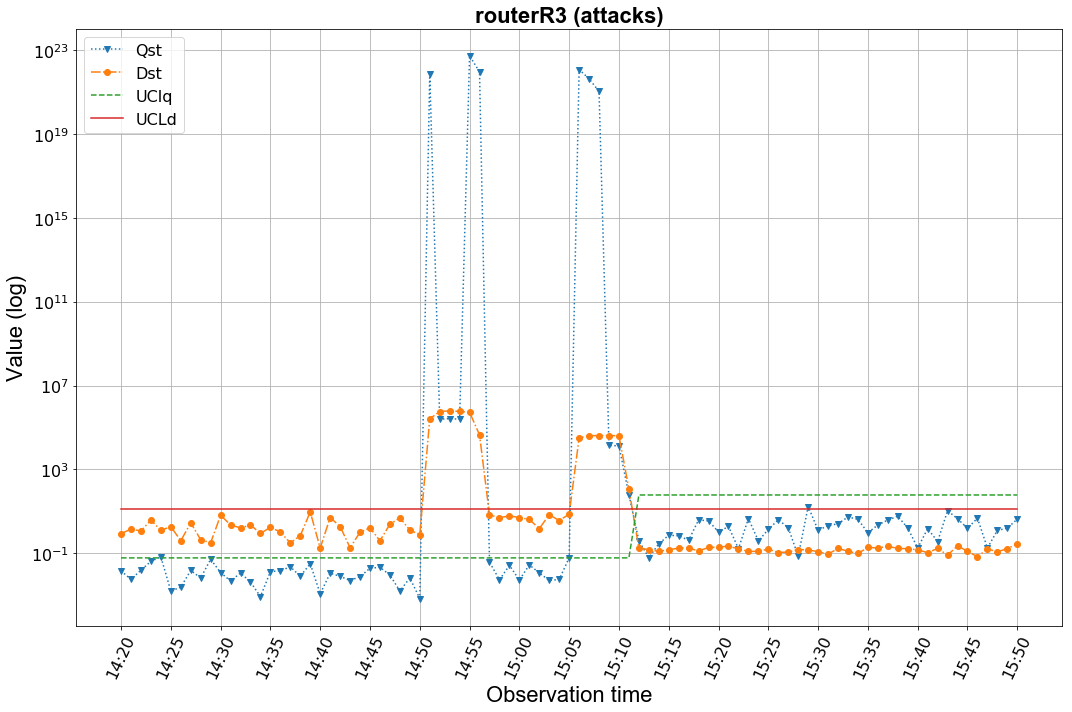

In [66]:
# All data gathered from the experiment ('all')
fig, ax = plt.subplots(figsize=(15,10))
draw_mon_graph(device_name=device_name,obs_interval='all',fig=fig, ax=ax, save=True, st=['Qst','Dst'], cl=['UCLq','UCLd'])
# The data considering the anomaly time interval ('anomaly') where the attacks took place.
fig, ax = plt.subplots(figsize=(15,10))
draw_mon_graph(device_name=device_name,obs_interval='anomaly',fig=fig, ax=ax, save=True, st=['Qst','Dst'], cl=['UCLq','UCLd'])